<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/dcgan64_normal_abnormal_modified_generator_loss_cifar10_dataset_DenseNet121_Fine_tuning_on_Generator_and_Discriminator_modified_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Here, we train the discriminator on samples from normal frames ###

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import time, os

In [3]:
print(round(time.time()))

1616127285


In [4]:
time_stamp = round(time.time())

In [5]:
cd /content/gdrive/MyDrive/Anomaly_Detection_Videos/

/content/gdrive/MyDrive/Anomaly_Detection_Videos


In [6]:
os.mkdir(str(time_stamp))


In [7]:
os.chdir(str(time_stamp))

In [8]:
time_stamp

1616127285

In [9]:
#!pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__

'2.4.1'

In [10]:
import tensorflow as tf

In [11]:
physical_devices =tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
from tensorflow.python.client import device_lib

# "GPU" + device_lib.list_local_devices()[-1].physical_device_desc.split(",")[1]

In [13]:
tf.__version__

'2.4.1'

In [14]:
import glob # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
import imageio # Imageio is a Python library that provides an easy interface to read and write a wide range of image data, including animated images, volumetric data, and scientific formats. 
%matplotlib inline 
import matplotlib.pyplot as plt 
import tensorflow.keras.layers as layers # Keras layers API
import time
from IPython import display # For displaying image

In [15]:
from tensorflow.keras.models import Model

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import PIL
import random

## Load dataset ##

In [17]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(X_train, X_train_label), (X_test, X_test_label) = load_data()
X_train_abnormal = []
X_train_normal = []

# plot images from the training dataset
for i in range(len(X_train)):
  if X_train_label[i] == 0 and len(X_train_abnormal) < 10: # few abnormal samples
    X_train_abnormal.append(X_train[i])
  elif X_train_label[i] == 1:
    X_train_normal.append(X_train[i])

In [18]:
X_train_normal = np.asarray(X_train_normal)
X_train_abnormal = np.asarray(X_train_abnormal)

In [19]:
len(X_train_normal)

5000

In [20]:
len(X_train_abnormal)

10

In [21]:
# expand to 3d, e.g. add channels dimension
#abnormal_data = np.expand_dims(X_train_abnormal, axis=-1)
#normal_data = np.expand_dims(X_train_normal, axis=-1)


In [22]:
abnormal_data = X_train_abnormal

In [23]:
train_images = X_train_normal.reshape(X_train_normal.shape[0], 32, 32, 3).astype('float32')
#train_images = (train_images - 127.5) / 127.5

train_images = (train_images) / 255.0


In [24]:
X_train_normal.shape[0]

5000

In [25]:
abnormal_data = abnormal_data.astype('float32')
#normal_data = normal_data.astype('float32')

abnormal_data = abnormal_data / 255.0
#normal_data = normal_data / 255.0

In [26]:
X_test_abnormal = []
X_test_normal = []

# plot images from the training dataset
for i in range(len(X_test)):
  if X_test_label[i] == 0: # few abnormal samples
    X_test_abnormal.append(X_test[i])
  elif X_test_label[i] == 1:
    X_test_normal.append(X_test[i])

In [27]:
# expand to 3d, e.g. add channels dimension
abnormal_data_test = np.expand_dims(X_test_abnormal, axis=0)

In [28]:
abnormal_data_test = abnormal_data_test.astype('float32')
abnormal_data_test = abnormal_data_test / 255.0

In [29]:
#abnormal_images = np.array(os.listdir(path_abnormal))
np.random.shuffle(abnormal_data_test)
BUFFER_SIZE = len(X_test_abnormal) #200000 # number of images in training i think
BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(abnormal_data_test)
abnormal_data_test = np.split(abnormal_data_test[:BUFFER_SIZE],BATCH_SIZE)

In [30]:
X_test_normal = np.asarray(X_test_normal)

In [31]:
test_normal_images = X_test_normal.reshape(X_test_normal.shape[0], 32, 32, 3).astype('float32')
#train_images = (train_images - 127.5) / 127.5

test_normal_images = (test_normal_images) / 255.0

In [32]:
test_normal_ds = tf.data.Dataset.from_tensor_slices(test_normal_images).shuffle(54077).batch(100000000)

In [33]:
# X_train_normal_np = X_train_normal_np.astype('float32') / 255.
# X_train_abnormal_np = X_train_abnormal_np.astype('float32') / 255.

In [34]:
# path = "/content/gdrive/MyDrive/Anomaly_Detection_Videos/normal_frames/"

In [35]:
# path_abnormal = "/content/gdrive/MyDrive/Anomaly_Detection_Videos/abnormal_frames/"

In [36]:
# def load_image( infilename ) :
#     img = PIL.Image.open( infilename )
#     #img = img.crop([25,65,153,193])
#     #img = img.resize((64,64))
#     img = img.resize((512,512))
#     data = np.asarray( img, dtype="int32" )
#     return data

In [37]:
latent_dim = 128
C = 3
img_width = img_height = 32

In [38]:
IMG_SIZE = (32, 32)

In [39]:
IMG_SHAPE = IMG_SIZE + (3,)

In [40]:
base_model_encoder = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [41]:
base_model_encoder.trainable = True

In [42]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_encoder.layers))

# Fine-tune from this layer onwards
fine_tune_at_encoder = 422

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_encoder.layers[:fine_tune_at_encoder]:
  layer.trainable =  False

Number of layers in the base model:  427


In [43]:
print(f'{len(base_model_encoder.layers) - fine_tune_at_encoder} layers fine-tuned at generator module')

5 layers fine-tuned at generator module


In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [45]:
def make_encoder_model():
  inputs = layers.Input(shape=(img_width, img_height, C), name="inputs")
  x = inputs

  # Fine-tuning the base layers

  x = base_model_encoder(inputs, training=False)
  x = global_average_layer(x)
  #x = tf.keras.layers.Dropout(0.2)(x)




  # x = layers.Conv2D(32, (3,3), padding="same")(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.LeakyReLU(alpha=0.2)(x)
  # x = layers.MaxPool2D((2,2))(x)

  # x = layers.Conv2D(32, (3,3), padding="same")(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.LeakyReLU(alpha=0.2)(x)
  # x = layers.MaxPool2D((2,2))(x)

  print('shape after encoder: ', x.shape)

  # x = layers.Flatten()(x)
  units = x.shape[1] * 2
  x = layers.Dense(latent_dim, name="latent")(x)

  return (x, inputs, units)

In [46]:
def make_generator_model(x, units):
  # Building the generator
  x = layers.Dense(units)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((8, 8, 32))(x) # reshape to shape after encoder

  x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.2)(x)

  x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("sigmoid", name="outputs")(x)

  outputs = x

  return outputs

In [47]:
x, inputs, units = make_encoder_model()

shape after encoder:  (None, 1024)


In [48]:
outputs = make_generator_model(x=x, units=units)

In [49]:
encoder_generator_network = Model(inputs=inputs, outputs=outputs)

In [50]:
print(x.shape)

(None, 128)


In [51]:
abnormal_data.shape

(10, 32, 32, 3)

In [52]:
#abnormal_images = np.array(os.listdir(path_abnormal))
np.random.shuffle(abnormal_data)
BUFFER_SIZE = len(X_train_abnormal) #200000 # number of images in training i think
BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# shuffle and batch the data
np.random.shuffle(abnormal_data)
# abnormal_data = np.split(abnormal_data[:BUFFER_SIZE],BATCH_SIZE)

abnormal_data = np.split(abnormal_data[:2500], 1)

In [53]:
# #abnormal_images = np.array(os.listdir(path_abnormal))
# np.random.shuffle(normal_data)
# BUFFER_SIZE = 5#200000 # number of images in training i think
# BATCH_SIZE = 1#500 # This is just the standard number for batch size. Google for more info
# # shuffle and batch the data
# np.random.shuffle(normal_data)
# #normal_data = np.split(normal_data[:BUFFER_SIZE],BATCH_SIZE)

In [54]:
train_normal_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(54077).batch(128)

In [55]:
#len(abnormal_data[0][1])

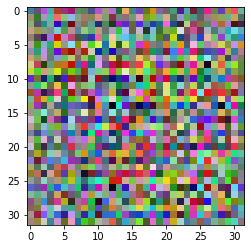

In [56]:
#generator = make_generator_model()

#noise = tf.random.normal([1, img_width,img_height, 1]) # shape is 1, 100
generated_image = encoder_generator_network(abnormal_data, training = True)
#plt.imshow(generated_image[0], interpolation="nearest" )
plt.imshow(generated_image[0])

In [57]:
len(generated_image)

10

In [58]:
IMG_SIZE = (32, 32)

In [59]:
IMG_SHAPE = IMG_SIZE + (3,)

In [60]:
base_model_disc = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [61]:
base_model_disc.trainable = True

In [62]:
#base_model.summary()

In [63]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_disc.layers))

# Fine-tune from this layer onwards
fine_tune_at_disc = 422

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_disc.layers[:fine_tune_at_disc]:
  layer.trainable =  False

Number of layers in the base model:  427


In [64]:
print(f'{len(base_model_disc.layers) - fine_tune_at_disc} layers fine-tuned at discriminator module')

5 layers fine-tuned at discriminator module


In [65]:
prediction_layer = tf.keras.layers.Dense(1)

In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 39,937
Non-trainable params: 6,998,592
_________________________________________________________________


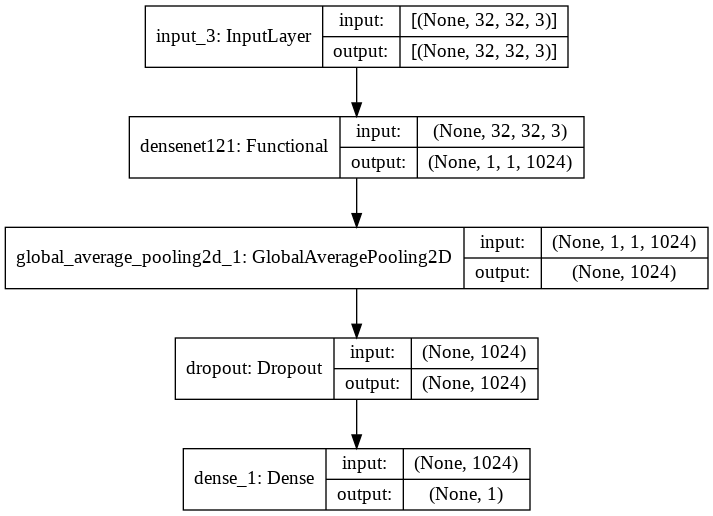

In [67]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


def define_discriminator():
  inputs = tf.keras.Input(shape=(32, 32, 3))
  #x = data_augmentation(inputs)
  #x = preprocess_input(x)
  x = base_model_disc(inputs, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  return model


 
# define the standalone discriminator model
def define_discriminator2(in_shape=(img_width, img_height, C)):
 model = Sequential()
 model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Dropout(0.4))
 model.add(Flatten())
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 #opt = Adam(lr=0.0002, beta_1=0.5)
 #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model
 
# define discriminator model
discriminator = define_discriminator()
# summarize the model
discriminator.summary()
# plot the model
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [68]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[ 0.51393193]
 [ 0.5063555 ]
 [ 0.3507194 ]
 [-0.32720387]
 [ 0.11388758]
 [ 0.6041291 ]
 [ 0.18062131]
 [ 0.14567418]
 [ 0.1654816 ]
 [-0.2555322 ]], shape=(10, 1), dtype=float32)


In [69]:
len(decision)

10

## Testing Abnormal data with discriminator ##

In [70]:
abn_data = np.expand_dims(abnormal_data[0][6], axis=0)

In [71]:
decision = discriminator(abn_data)
print(decision) # discriminator decision should be close to 0

tf.Tensor([[0.6881598]], shape=(1, 1), dtype=float32)


In [72]:
type(abn_data)

numpy.ndarray

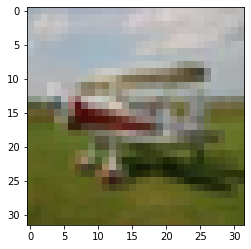

In [73]:
plt.imshow(tf.squeeze(abn_data))

In [74]:
train_images[0].shape

(32, 32, 3)

## Testing Normal data with discriminator ##

In [75]:
nor_data = np.expand_dims(train_images[2510], axis=0)

In [76]:
decision = discriminator(nor_data)
print(decision) # discriminator decision should be close to 1

tf.Tensor([[-0.56567353]], shape=(1, 1), dtype=float32)


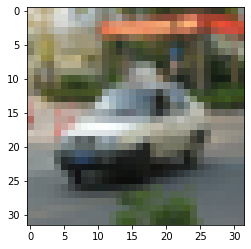

In [77]:
plt.imshow(tf.squeeze(nor_data))

In [78]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

"""
Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predicitions on real images to an array of 1s
and the dicriminator's predicitons on fake (generated) images to an array of 0s.
"""
@tf.function
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  #abnormal_loss = cross_entropy(tf.zeros_like(abnormal_output), abnormal_output)

  #total_loss = real_loss + fake_loss + abnormal_loss
  total_loss = real_loss + fake_loss
  
  return total_loss

"""
Generator Loss

The generator's loss quantifies how well it was able to trick the discrimator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
Here, we will compare the discriminators decisions on the generated images to an array of 1s.
"""
@tf.function
def generator_loss(fake_output):
  # pick abnormal image at random for optimization
  i = random.randint(0, len(abnormal_data))
  print(f'i = {i}')

  loss_1 = cross_entropy(tf.ones_like(fake_output), fake_output)
  #loss_2 = cross_entropy(tf.ones_like(abnormal_data[0][i]), abnormal_data[0][i])
  #loss_2 = cross_entropy(tf.ones_like(generated_images[i]), abnormal_data[0][i])
  #loss_2 = cross_entropy(tf.zeros_like(abnormal_output), abnormal_output)
  total_loss = loss_1
  return total_loss

"""
The discriminator and the generator optimizers are different since we will train two networks separately.
The Adam optimization algorithm is an extension to stochastic gradient descent.
Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.
A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [79]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = encoder_generator_network,
                                 discriminator = discriminator)

In [80]:
checkpoint_prefix

'./training_checkpoints/ckpt'

In [81]:
# We will reuse this seed overtime (so it's easier) to visualize progress in the animated GIF
#tf.random.set_seed(1234)
noise_dim = 100
num_examples_to_generate = 16
#seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=1)

In [82]:
EPOCHS = 100

In [83]:
"""
The training loop begins with generator receiving a random seed as input. 
That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
"""

# Notice the use of tf.function
# This annotation causes the function to be "compiled"
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # take the image links and return a cropped image
    # new_images = []
    # for file_name in images:
    #     #new_pic = load_image( path + file_name)
    #     #new_images.append(new_pic)
    #     new_images.append(file_name)
    
    # images = np.array(new_images)
    #images = images.reshape(images.shape[0], img_width, img_height, C).astype('float32') # puts each number in its own numpy array so instead of [1,2,3] gonna be [[1], [2], [3]]
    #images = (images) / 255 # normalize to [0,1]
    


    """
GradientTape() Records operations for automatic differentiation. Operations are recorded if 
they are executed within this context manager and at least one of their inputs is being "watched".
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = encoder_generator_network(abnormal_data, training=True)

      real_output = discriminator(images, training=True) # images constist of only normal samples
      #abnormal_output = discriminator(abnormal_data, training=True) # abnormal_data constist of only abnormal samples
      fake_output = discriminator(generated_images, training=True)

      #gen_loss = generator_loss(generated_images=generated_images, fake_output=fake_output)
      gen_loss = generator_loss(fake_output=fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, encoder_generator_network.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, encoder_generator_network.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    images = None

In [84]:
# ended at 20 epocsh

In [85]:
  # To plot model performance at various epochs on abnormal and normal samples
  chart_abnormal = []
  chart_normal = []
  chart_epoch = []

In [86]:
def discriminator_inference(X_test_abnormal, X_test_normal, epoch):
  """function to calculate discriminator score on text data"""
  print(f'Abnormal-count{"Normal-count":>17}')
  # print(f'{len(predictions_abnormal_test[0]):>14}{len(decision_test_normal[0]):>14}')

  predictions_abnormal_test = []

  # # To plot model performance at various epochs on abnormal and normal samples
  # chart_abnormal = []
  # chart_normal = []
  # chart_epoch = []

  for index, data in enumerate(abnormal_data_test[0]):
    abn_data_2 = abnormal_data_test[0][index]
    predictions_abnormal_test.append(discriminator(abn_data_2))


  count_test_abnormal = 0

  for ind, _ in enumerate(predictions_abnormal_test[0]):
    if (tf.keras.backend.get_value(predictions_abnormal_test[0][ind])) < 0: # setting a threshold of 0.9
      count_test_abnormal += 1

  print('Abnormal correct count: ', count_test_abnormal)


  decision_test_normal = []

  for index, img in enumerate(test_normal_ds):
    decision = discriminator(img)
    decision_test_normal.append(decision)
    #print(decision) # discriminator decision should be close to 1


  count_test_normal = 0

  for ind, _ in enumerate(decision_test_normal[0]):
    if (tf.keras.backend.get_value(decision_test_normal[0][ind]))[0] >= 0: # setting a threshold of 0.9
      #print(decision_test_normal[ind])
      count_test_normal += 1
  print('Normal correct count: ', count_test_normal)


  chart_abnormal.append(count_test_abnormal)
  chart_normal.append(count_test_normal)
  chart_epoch.append(epoch)

  # return (chart_abnormal, chart_normal, chart_epoch)

In [87]:
#@tf.function
def train(dataset, epochs):  
  tf.print("Starting man!")
  for epoch in range(epochs):
    start = time.time()
    tf.print("Starting Epoch:", epoch)
    batch_count = 1
    for image_batch in dataset:
      #tf.print("Batch:", batch_count)
      train_step(image_batch)
      #print("Batch:", batch_count, "Complete")
      batch_count += 1
    

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(encoder_generator_network,
                             epoch + 1,
                             abnormal_data)
    
    tf.print("Epoch:", epoch, "finished")
    tf.print()
    
    # Save the model every epochs
    #checkpoint.save(file_prefix = checkpoint_prefix)
    
    tf.print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    if epoch % EPOCHS == 0:
       checkpoint.save(file_prefix = checkpoint_prefix)  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(encoder_generator_network,
                           epochs,
                           abnormal_data)

In [88]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(abnormal_data, training=False).numpy()

  fig = plt.figure(figsize=(150,150))
  print(f'No of predictions: {predictions.shape[0]}')

  #plt.imshow(tf.squeeze(predictions[0]), cmap='gray')
  
  for i in range(9):
      plt.subplot(3, 3, i+1)
      plt.imshow(tf.squeeze(predictions[i]))
      #plt.axis('off')

      discriminator_inference(X_test_abnormal, X_test_normal, epoch)
      if epoch % 2 == 0:
        pass
        #discriminator_inference(X_test_abnormal, X_test_normal, epoch)
        # plot_model_performance(ch_abnormal, ch_normal, ch_epoch)      
         #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [89]:
from IPython.display import Image
#Image(filename='image_at_epoch_0060.png') 

In [90]:
type(train_normal_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [91]:
%%time
train(train_normal_dataset, EPOCHS)

No of predictions: 10
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304
Abnormal-count     Normal-count
Abnormal correct count:  735
Normal correct count:  304


CPU times: user 1h 16min 58s, sys: 1min 19s, total: 1h 18min 17s
Wall time: 1h 16min


In [92]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [93]:
!ls ../

1615326516  1615773306	1615870626  1616127285
1615332968  1615777718	1615872947  abnormal_frames
1615339238  1615836674	1615918234  disc_model
1615341768  1615857695	1615918985  discriminator.h5
1615390640  1615858218	1615944068  discriminator_plot.png
1615418536  1615858365	1615946534  encoder_generator.h5
1615420816  1615858568	1615947942  gen_model
1615425903  1615858603	1615995699  image_at_epoch_0002.png
1615427670  1615858762	1615997078  image_at_epoch_10000.png
1615433020  1615858911	1615999340  image_at_epoch_1000.png
1615434351  1615860230	1616123575  image_at_epoch_2000.png
1615486737  1615860462	1616124476  image_at_epoch_3000.png
1615490214  1615860555	1616124794  image_at_epoch_4000.png
1615494133  1615862948	1616124815  image_at_epoch_5000.png
1615494251  1615863045	1616124882  image_at_epoch_6000.png
1615495849  1615863078	1616124989  image_at_epoch_7000.png
1615503783  1615863354	1616125147  image_at_epoch_8000.png
1615520901  1615865098	1616125433  image_at_epoch_9000.

## Inferencing Discriminator on X_test ##

In [94]:
def plot_model_performance(ch_abnormal, ch_normal, ch_epoch):
  """ the function plots abnormal and normal model performance at varying epochs"""
  plt.title('Model performance on test data')
  plt.xlabel('epochs')
  plt.ylabel('samples correctly classified')
  plt.plot(ch_epoch, ch_abnormal, label='Abnormal')
  plt.plot(ch_epoch, ch_normal, label='Normal')
  plt.legend()
  plt.grid()
  plt.show()

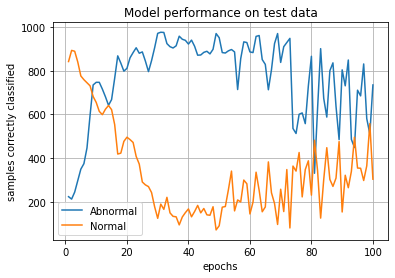

In [95]:
plot_model_performance(chart_abnormal, chart_normal, chart_epoch)

In [96]:
 print(chart_abnormal)
  

[224, 224, 224, 224, 224, 224, 224, 224, 224, 213, 213, 213, 213, 213, 213, 213, 213, 213, 245, 245, 245, 245, 245, 245, 245, 245, 245, 297, 297, 297, 297, 297, 297, 297, 297, 297, 350, 350, 350, 350, 350, 350, 350, 350, 350, 375, 375, 375, 375, 375, 375, 375, 375, 375, 447, 447, 447, 447, 447, 447, 447, 447, 447, 596, 596, 596, 596, 596, 596, 596, 596, 596, 735, 735, 735, 735, 735, 735, 735, 735, 735, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 747, 716, 716, 716, 716, 716, 716, 716, 716, 716, 681, 681, 681, 681, 681, 681, 681, 681, 681, 642, 642, 642, 642, 642, 642, 642, 642, 642, 668, 668, 668, 668, 668, 668, 668, 668, 668, 765, 765, 765, 765, 765, 765, 765, 765, 765, 868, 868, 868, 868, 868, 868, 868, 868, 868, 835, 835, 835, 835, 835, 835, 835, 835, 835, 798, 798, 798, 798, 798, 798, 798, 798, 798, 811, 811, 811, 811, 811, 811, 811, 811, 811, 859, 859, 859, 859, 859, 859, 859, 859, 859, 883, 883, 883, 883, 883, 883, 883, 883, 883, 905, 905,

In [97]:
print(chart_normal)


[842, 842, 842, 842, 842, 842, 842, 842, 842, 893, 893, 893, 893, 893, 893, 893, 893, 893, 889, 889, 889, 889, 889, 889, 889, 889, 889, 840, 840, 840, 840, 840, 840, 840, 840, 840, 776, 776, 776, 776, 776, 776, 776, 776, 776, 759, 759, 759, 759, 759, 759, 759, 759, 759, 745, 745, 745, 745, 745, 745, 745, 745, 745, 731, 731, 731, 731, 731, 731, 731, 731, 731, 682, 682, 682, 682, 682, 682, 682, 682, 682, 655, 655, 655, 655, 655, 655, 655, 655, 655, 614, 614, 614, 614, 614, 614, 614, 614, 614, 599, 599, 599, 599, 599, 599, 599, 599, 599, 624, 624, 624, 624, 624, 624, 624, 624, 624, 641, 641, 641, 641, 641, 641, 641, 641, 641, 622, 622, 622, 622, 622, 622, 622, 622, 622, 554, 554, 554, 554, 554, 554, 554, 554, 554, 419, 419, 419, 419, 419, 419, 419, 419, 419, 423, 423, 423, 423, 423, 423, 423, 423, 423, 477, 477, 477, 477, 477, 477, 477, 477, 477, 496, 496, 496, 496, 496, 496, 496, 496, 496, 485, 485, 485, 485, 485, 485, 485, 485, 485, 472, 472, 472, 472, 472, 472, 472, 472, 472, 408, 408,

In [98]:
print(chart_epoch)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

In [99]:
---

SyntaxError: ignored

## Discriminator score on abnormal images ##

In [ ]:
# predictions_abnormal_test = []

# for index, data in enumerate(abnormal_data_test[0]):
#   #abn_data_2 = np.expand_dims(abnormal_data_test[0][index], axis=0)
#   abn_data_2 = abnormal_data_test[0][index]
#   predictions_abnormal_test.append(discriminator(abn_data_2))
#   #print(discriminator(abn_data_2))

In [ ]:
# len(predictions_abnormal_test[0])

In [ ]:
# count_test_abnormal = 0

# for ind, _ in enumerate(predictions_abnormal_test[0]):
#   if (tf.keras.backend.get_value(predictions_abnormal_test[0][ind])) < 0: # setting a threshold of 0.9
#     count_test_abnormal += 1
# print('Abnormal correct count: ', count_test_abnormal)

In [ ]:
# print(f'{count_test_abnormal} abnormal missed' )

In [ ]:
# decision_test_normal = []

# for index, img in enumerate(test_normal_ds):
#   #nor_data_test = np.expand_dims(test_normal_images[int(index)], axis=0)
#   #nor_data_test = test_normal_ds

#   decision = discriminator(img)
#   decision_test_normal.append(decision)
#   #print(decision) # discriminator decision should be close to 1

In [ ]:
# len(decision_test_normal[0])

In [ ]:
(tf.keras.backend.get_value(decision_test_normal[0][0]))[0]

In [ ]:
# count_test_normal = 0

# for ind, _ in enumerate(decision_test_normal[0]):
#   if (tf.keras.backend.get_value(decision_test_normal[0][ind]))[0] >= 0: # setting a threshold of 0.9
#     #print(decision_test_normal[ind])
#     count_test_normal += 1
# print('Normal correct count: ', count_test_normal)

In [ ]:
# print(f'{len(decision_test_normal[0]) - count_test_normal} normal missed' )

## Save models ##

In [ ]:
#encoder_generator_network.save('encoder_generator.h5')

In [ ]:
#discriminator.save('discriminator.h5')

In [ ]:
----

In [ ]:
fig = plt.figure(figsize=(4,4))
predictions = checkpoint.generator(x_abnormal, training = False).numpy()
for i in range(seed.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i], interpolation="nearest")
    plt.axis('off')
    
plt.show()

In [ ]:
noise = tf.random.normal([1,100]) # shape is 1, 100
random_face = checkpoint.generator(noise, training = False).numpy()[0]
plt.imshow(random_face, interpolation='nearest')
plt.axis("off")
plt.show()

In [ ]:
%ls

In [ ]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('dcgan.gif', 'dcgan_celebA.gif.png')

In [ ]:
display.Image(filename="dcgan_celebA.gif.png")

In [ ]:
%ls training_checkpoints/

%cp image_at_epoch_0001.png play-with-faces/